# Quantifying Translation Efficiency
A Jupyter Notebook Python coding environment employs existing RNA-seq and Ribo-seq datasets to identify ORFs and calculate translation across them. Relative intensities of RNA-seq and Ribo-seq data are calculated across each ORF and divided to produce ratios indicating translational efficiency.

### Outputs
-  .csv result tables display each trimmed ORF with its translational efficiency ratio and  relevant flags
-  visual plots (.png) generated from Seaborn package

### Notebook setup

In [ ]:
# Navigate to directory of input datasets
%cd 'Mtb_inputs/'

/Users/annamccartan/Downloads/Leaderless-Efficiency/Mtb_inputs


In [2]:
# load libraries
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio.Seq import Seq
from Bio import SeqIO

sns.set_palette("Set2")
color_palette = list(sns.color_palette("Set2").as_hex())
#print(sns.color_palette("Set2").as_hex())

In [3]:
# set display parameters
pd.options.display.float_format = "{:8,.3f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [4]:
# set values for later plotting
orf_min = 25 # minimum orf length; lengths below orf_min are flagged & dropped
perc_min = 10 # RNASeq percentile cutoff; RNASeq intensities below this level are flagged & dropped
min_data_pts = 40 # plotting returns error if num data points in any group dips below this quota
utr_length = 0 # adjust to compare different UTR lengths

### Import datasets
- genome reference sequence (genome_FASTA, .fasta)
- Table containing coordinate/strand of all known TSSs (TSS, .bed)
- Annotated genes: start base, end base, strand & name (AnnotatedGenes, .bed)
- Ribo-seq data: base values and corresponding ribosomal intensity (Ribosome footprint, .bedgraph)
- RNA-seq data: base values and corresponding RNA intensity (RNA-seq, .bedgraph)
- Ribo-RET data: base values and corresponding ribosomal intensity at initiation site (Ribo-RET footprint, .bedgraph)
- Protein reference sequence (protein_FASTA, .fasta)

In [5]:
for record in SeqIO.parse("genome_FASTA.fasta", "fasta"):
    sequence = record.seq
    sequence_comp = sequence.complement() # convert to sequence complement
    reference_seq = str(sequence)
    complement_seq = str(sequence_comp)
    
tss_df = pd.read_csv("TSS.bed", sep = "\t", skiprows=1, header=None) # import TSS data

tss_df_pos = tss_df[tss_df[5]=="+"]
tss_df_neg = tss_df[tss_df[5]=="-"]

tss_list_pos = list(tss_df_pos[2])
tss_list_neg = list(tss_df_neg[2])

In [6]:
tss_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,NC_000962.3,113,114,114+_Cortes_only,NaN,+,NaN,NaN,NaN,NaN,NaN
1,NC_000962.3,114,115,115+_Shell_only,NaN,+,NaN,NaN,NaN,NaN,NaN
2,NC_000962.3,434,435,435-_Shell_only,NaN,-,NaN,NaN,NaN,NaN,NaN
3,NC_000962.3,537,538,538+_Cortes_only,NaN,+,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,1266,1267,1267-_Cortes_Shell_shared,NaN,-,NaN,NaN,NaN,NaN,NaN


In [7]:
# import annotated genes data, separate genes on positive and negative strands
annotated_genes_df = pd.read_csv("AnnotatedGenes.bed", sep = "\t", skiprows=1, header=None) 
annotated_genes_df_pos = annotated_genes_df[annotated_genes_df[5]=="+"]
annotated_genes_df_neg = annotated_genes_df[annotated_genes_df[5]=="-"]

# from data, create dictionary relating start of gene to end
annotated_genes_dict_pos = dict (zip(annotated_genes_df_pos[1]+1, annotated_genes_df_pos[2]))
annotated_genes_dict_neg = dict (zip(annotated_genes_df_neg[1]+1, annotated_genes_df_neg[2]))

# obtain list of keys in dictionary
annotated_genes_keys_pos = list(annotated_genes_dict_pos.keys())
annotated_genes_keys_neg = list(annotated_genes_dict_neg.keys())

# extract names of annotated genes
annotatedgenenames_dict_pos = dict (zip(annotated_genes_df_pos[1]+1, annotated_genes_df_pos[3]))
annotatedgenenames_dict_neg = dict (zip(annotated_genes_df_neg[1]+1, annotated_genes_df_neg[3]))

In [8]:
annotated_genes_df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,NC_000962.3,1597905,1598883,whiA,NaN,+,NaN,NaN,NaN,NaN,NaN
1,NC_000962.3,1598892,1599654,Rv1424c,NaN,-,NaN,NaN,NaN,NaN,NaN
2,NC_000962.3,1599657,1601037,Rv1425,NaN,+,NaN,NaN,NaN,NaN,NaN
3,NC_000962.3,1601058,1602321,lipO,NaN,-,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,1602320,1603928,fadD12,NaN,-,NaN,NaN,NaN,NaN,NaN


In [9]:
# import ribo-seq data
ribo_seq_1plus = pd.read_csv("Ribosome footprint 1 plus.bedgraph", sep = "\t", skiprows=1, header=None)
ribo_seq_1minus = pd.read_csv("Ribosome footprint 1 minus.bedgraph", sep = "\t", skiprows=1, header=None)
ribo_seq_2plus = pd.read_csv("Ribosome footprint 2 plus.bedgraph", sep = "\t", skiprows=1, header=None)
ribo_seq_2minus = pd.read_csv("Ribosome footprint 2 minus.bedgraph", sep = "\t", skiprows=1, header=None)

# from ribosomal seq data, create dictionary relating base to intensity
ribo_seq_dict_1plus = dict (zip(ribo_seq_1plus[2], ribo_seq_1plus[3]))
ribo_seq_dict_1minus = dict (zip(ribo_seq_1minus[2], ribo_seq_1minus[3]))
ribo_seq_dict_2plus = dict (zip(ribo_seq_2plus[2], ribo_seq_2plus[3]))
ribo_seq_dict_2minus = dict (zip(ribo_seq_2minus[2], ribo_seq_2minus[3]))

In [10]:
# import rna-seq data
rna_seq_1plus = pd.read_csv("RNA-seq 1 plus.bedgraph", sep = "\t", skiprows=1, header=None)
rna_seq_1minus = pd.read_csv("RNA-seq 1 minus.bedgraph", sep = "\t", skiprows=1, header=None)
rna_seq_2plus = pd.read_csv("RNA-seq 2 plus.bedgraph", sep = "\t", skiprows=1, header=None)
rna_seq_2minus = pd.read_csv("RNA-seq 2 minus.bedgraph", sep = "\t", skiprows=1, header=None)

# from rna-seq data, create dictionary relating base to intensity
rna_seq_dict_1plus = dict(zip(rna_seq_1plus[2], rna_seq_1plus[3]))
rna_seq_dict_1minus = dict(zip(rna_seq_1minus[2], rna_seq_1minus[3]))
rna_seq_dict_2plus = dict(zip(rna_seq_2plus[2], rna_seq_2plus[3]))
rna_seq_dict_2minus = dict(zip(rna_seq_2minus[2], rna_seq_2minus[3]))

### Calculate Intensity Coverage

In [11]:
# calculates sum of intensity values over range of bases
def sum_intensities(dataset, left, right):
    intensity_sum = 0
    for i in range(left, right+1):
        intensity_sum = intensity_sum + dataset[i]    
    return intensity_sum

In [12]:
# calculate ribosomal seq intensity sums
ribo_seq_sum_1plus = sum_intensities(dataset = ribo_seq_dict_1plus, left = 1, right = len(reference_seq))
ribo_seq_sum_1minus = sum_intensities(dataset = ribo_seq_dict_1minus, left = 1, right = len(reference_seq))
ribo_seq_sum_2plus = sum_intensities(dataset = ribo_seq_dict_2plus, left = 1, right = len(reference_seq))
ribo_seq_sum_2minus = sum_intensities(dataset = ribo_seq_dict_2minus, left = 1, right = len(reference_seq))
ribo_seq_total1 = ribo_seq_sum_1plus + ribo_seq_sum_1minus
ribo_seq_total2 = ribo_seq_sum_2plus + ribo_seq_sum_2minus

# calculate rna-seq intensity sums
rna_seq_sum_1plus = sum_intensities(dataset = rna_seq_dict_1plus, left = 1, right = len(reference_seq))
rna_seq_sum_1minus = sum_intensities(dataset = rna_seq_dict_1minus, left = 1, right = len(reference_seq))
rna_seq_sum_2plus = sum_intensities(dataset = rna_seq_dict_2plus, left = 1, right = len(reference_seq))
rna_seq_sum_2minus = sum_intensities(dataset = rna_seq_dict_2minus, left = 1, right = len(reference_seq))
rna_seq_total1 = rna_seq_sum_1plus + rna_seq_sum_1minus
rna_seq_total2 = rna_seq_sum_2plus + rna_seq_sum_2minus

In [13]:
# calculate RNA-seq coverage per base for all annotated orfs
rna_density_list = []
for orf in annotated_genes_dict_pos:
    orf_length = annotated_genes_dict_pos[orf] - orf
    rna_coverage1 = sum_intensities(dataset = rna_seq_dict_1plus, left = orf, right = annotated_genes_dict_pos[orf])
    rna_coverage1_norm = (rna_coverage1/rna_seq_total1)*1000000000
    rna_coverage2 = sum_intensities(dataset = rna_seq_dict_2plus, left = orf, right = annotated_genes_dict_pos[orf])
    rna_coverage2_norm = (rna_coverage2/rna_seq_total2)*1000000000
    avg_rna_coverage = (rna_coverage1_norm + rna_coverage2_norm) / 2
    rna_coverage_density = avg_rna_coverage/(orf_length+1)
    rna_density_list.append(rna_coverage_density)

for orf in annotated_genes_dict_neg:
    orf_length = annotated_genes_dict_neg[orf] - orf
    rna_coverage1 = sum_intensities(dataset = rna_seq_dict_1minus, left = orf, right = annotated_genes_dict_neg[orf])
    rna_coverage1_norm = (rna_coverage1/rna_seq_total1)*1000000000
    rna_coverage2 = sum_intensities(dataset = rna_seq_dict_2minus, left = orf, right = annotated_genes_dict_neg[orf])
    rna_coverage2_norm = (rna_coverage2/rna_seq_total2)*1000000000
    avg_rna_coverage = (rna_coverage1_norm + rna_coverage2_norm) / 2 
    rna_coverage_density = avg_rna_coverage/(orf_length+1)
    rna_density_list.append(rna_coverage_density)

rna_percentile_cutoff = (np.percentile(rna_density_list, perc_min)) # determine value for desired percentile cutoff

In [14]:
# ratio calculation
annotated_ratio_list_pos = []
annotated_ratio_list_neg = []
for orf in annotated_genes_dict_pos:
    orf_length = annotated_genes_dict_pos[orf] - orf
    
    # calculate RNA-seq coverage per base for all annotated orfs
    rna_coverage1 = sum_intensities(dataset = rna_seq_dict_1plus, left = orf, right = annotated_genes_dict_pos[orf])
    rna_coverage1_norm = (rna_coverage1/rna_seq_total1)*1000000000
    rna_coverage2 = sum_intensities(dataset = rna_seq_dict_2plus, left = orf, right = annotated_genes_dict_pos[orf])
    rna_coverage2_norm = (rna_coverage2/rna_seq_total2)*1000000000
    avg_rna_coverage = (rna_coverage1_norm + rna_coverage2_norm) / 2
    rna_coverage_density = avg_rna_coverage/(orf_length+1)

    # calculate Ribosomal seq coverage per base for all annotated orfs
    ribo_coverage1 = sum_intensities(dataset = ribo_seq_dict_1plus, left = orf, right = annotated_genes_dict_pos[orf])
    ribo_coverage1_norm = (ribo_coverage1/ribo_seq_total1)*1000000000
    ribo_coverage2 = sum_intensities(dataset = ribo_seq_dict_2plus, left = orf, right = annotated_genes_dict_pos[orf])
    ribo_coverage2_norm = (ribo_coverage2/ribo_seq_total2)*1000000000
    avg_ribo_coverage = (ribo_coverage1_norm + ribo_coverage2_norm) / 2
    ribo_coverage_density = avg_ribo_coverage/(orf_length+1)
    
    if (rna_coverage_density > rna_percentile_cutoff):
        annotated_ratio = ribo_coverage_density / rna_coverage_density # for top 90th percentile of RNA-seq coverage, calculate ratios
        annotated_ratio_list_pos.append(annotated_ratio)
    else:
        annotated_ratio_list_pos.append(np.nan)
    
for orf in annotated_genes_dict_neg:
    orf_length = annotated_genes_dict_neg[orf] - orf
    
    rna_coverage1 = sum_intensities(dataset = rna_seq_dict_1minus, left = orf, right = annotated_genes_dict_neg[orf])
    rna_coverage1_norm = (rna_coverage1/rna_seq_total1)*1000000000
    rna_coverage2 = sum_intensities(dataset = rna_seq_dict_2minus, left = orf, right = annotated_genes_dict_neg[orf])
    rna_coverage2_norm = (rna_coverage2/rna_seq_total2)*1000000000
    avg_rna_coverage = (rna_coverage1_norm + rna_coverage2_norm) / 2
    rna_coverage_density = avg_rna_coverage/(orf_length+1)
    
    ribo_coverage1 = sum_intensities(dataset = ribo_seq_dict_1minus, left = orf, right = annotated_genes_dict_neg[orf])
    ribo_coverage1_norm = (ribo_coverage1/ribo_seq_total1)*1000000000
    ribo_coverage2 = sum_intensities(dataset = ribo_seq_dict_2minus, left = orf, right = annotated_genes_dict_neg[orf])
    ribo_coverage2_norm = (ribo_coverage2/ribo_seq_total2)*1000000000
    avg_ribo_coverage = (ribo_coverage1_norm + ribo_coverage2_norm) / 2
    ribo_coverage_density = avg_ribo_coverage/(orf_length+1)
    
    if (rna_coverage_density > rna_percentile_cutoff):
        annotated_ratio =  ribo_coverage_density / rna_coverage_density
        annotated_ratio_list_neg.append(annotated_ratio)
    else:
        annotated_ratio_list_neg.append(np.nan)

### Define Functions

In [15]:
# identifies valid TSSs based on given 5' UTR length
def find_tss_matches(utr_length):
    start_list_pos = []
    start_list_neg = []
    for tss in tss_list_pos: # for each TSS on pos strand, analyze substring start
        start_base = tss+utr_length-1 # can adjust to look at TSSs w/ ATG/GTG at position +2, +3, +4, etc.
        end_base = start_base+3
        codon = reference_seq[start_base:end_base]
        if codon=="ATG" or codon=="GTG":
            if (reference_seq.find("ATG", start_base-utr_length, start_base+1) == -1): # ensure this is the first appearance of the start codon since the TSS
                if ((reference_seq.find("GTG", start_base-utr_length, start_base+1) == -1)):
                    start_list_pos.append(start_base+1) # store ATG/GTG start sites in list
    
    for tss in tss_list_neg:
        end_base = tss-utr_length # can adjust to look at TSSs w/ ATG/GTG at position -2, -3, -4, etc.
        start_base = end_base-3
        codon = reference_seq[start_base:end_base]
        if codon=="CAT" or codon=="CAC":
            if (reference_seq.find("CAT", end_base-1, end_base+utr_length) == -1): # ensure this is the first appearance of the start codon since the TSS
                if (reference_seq.find("CAC", end_base-1, end_base+utr_length) == -1):
                    start_list_neg.append(end_base) # store ATG/GTG start sites in list  
    
    return start_list_pos, start_list_neg

In [16]:
# defines open reading frame based on list of starting bases
def predict_orfs(start_list_pos, start_list_neg):  
    end_list_pos = []
    for i in range(len(start_list_pos)): # iterate through positive start site list, determine end of open reading frame
        current_left = start_list_pos[i]-1
        stop_codon_found = False
        while(stop_codon_found == False):
            current_right = current_left+3
            current_codon = reference_seq[current_left:current_right]
            if current_codon=="TAG" or current_codon=="TGA" or current_codon=="TAA":
                end_list_pos.append(current_right)
                i=i+1
                stop_codon_found = True
            else:
                current_left = current_right
    
    end_list_neg = []
    for i in range(len(start_list_neg)): # iterate through negative start site list, determine end of open reading frame
        current_right = start_list_neg[i]
        stop_codon_found = False
        while(stop_codon_found == False):
            current_left = current_right-3
            current_codon = reference_seq[current_left:current_right]
            if current_codon=="CTA" or current_codon=="TCA" or current_codon=="TTA":
                end_list_neg.append(current_left+1)
                i=i+1
                stop_codon_found = True
            else:
                current_right = current_left
    
    orf_dict_pos = dict(zip(start_list_pos, end_list_pos))
    orf_dict_neg = dict(zip(end_list_neg, start_list_neg))
    
    return orf_dict_pos, orf_dict_neg

In [17]:
# detects overlapping orfs, trims accordingly
def adjust_overlap(orf_dict_pos, orf_dict_neg):
    # positive strand
    annotated_list_pos = [0 for x in range(len(reference_seq))] # create list of zeroes for each base in the fasta sequence
    for key in annotated_genes_dict_pos:
        for num in (list(range(key, annotated_genes_dict_pos[key]+1))):
            annotated_list_pos[num] += 1 # adjust values to represent number of annotated genes at each location
    
    orf_dict_pos_adjusted = {}
    start_match_pos = []
    stop_match_pos = []
    gene_match_list_pos = []
    embedded_gene_list_pos = [] # store ORFs with genes embedded in them
    
    for orf in orf_dict_pos: # examine each identified orf
        has_embedded_gene = False
        for annotatedorf in annotated_genes_dict_pos:
            if orf < annotatedorf and orf_dict_pos[orf] > annotated_genes_dict_pos[annotatedorf]: # detects (rare) case of annotated ORF embedded in leaderless ORF
                has_embedded_gene = True
        if has_embedded_gene == False:
            embedded_gene_list_pos.append(False)
        else:
            embedded_gene_list_pos.append(True)
        
        if orf in annotated_genes_dict_pos:
            start_match_pos.append(True) # if start codon matches, take note
            gene_match_list_pos.append(annotatedgenenames_dict_pos[orf])
            annotated_ratio_list_pos[annotated_genes_keys_pos.index(orf)] = np.nan
        else:
            start_match_pos.append(False)
            gene_match_list_pos.append("N/A")
        
        if orf_dict_pos[orf] in annotated_genes_dict_pos.values():
            orf_dict_pos_adjusted[orf] = orf_dict_pos[orf] # if stop codons match, entire orf is examined
            stop_match_pos.append(True)
        else:
            orf_range = list(range(orf, orf_dict_pos[orf]+1))
            revised_orf_pos = [x for x in orf_range if annotated_list_pos[x] == 0] # if match is partial, only consider segment that doesn"t overlap with annotated gene
            
            if len(revised_orf_pos) == 0:
                orf_dict_pos_adjusted[orf] = 0 # delete orfs embedded in genes
                stop_match_pos.append(False)
            else:
                orf_dict_pos_adjusted[revised_orf_pos[0]] = revised_orf_pos[-1]
                stop_match_pos.append(False)
                
    # negative strand
    annotated_list_neg = [0 for x in range(len(reference_seq))] # create list of zeroes for each base in the fasta sequence
    for key in annotated_genes_dict_neg:
        for num in (list(range(key, annotated_genes_dict_neg[key]+1))):
            annotated_list_neg[num] += 1 # adjust values to represent number of annotated genes at each location
            
    orf_dict_neg_adjusted = {}
    stop_match_neg = []
    start_match_neg = []
    gene_match_list_neg = []
    embedded_gene_list_neg = []
    
    for orf in orf_dict_neg: # examine each identified orf
        has_embedded_gene = False
        for annotatedorf in annotated_genes_dict_neg:
            if orf < annotatedorf and orf_dict_neg[orf] > annotated_genes_dict_neg[annotatedorf]:
                has_embedded_gene = True
        if has_embedded_gene == False:
            embedded_gene_list_neg.append(False)
        else:
            embedded_gene_list_neg.append(True)
        
        if orf_dict_neg[orf] in annotated_genes_dict_neg.values():
            start_match_neg.append(True) # if start codon matches, take note
        else:
            start_match_neg.append(False)
        
        if orf in annotated_genes_dict_neg:
            orf_dict_neg_adjusted[orf] = orf_dict_neg[orf] # if stop codons match, entire orf is examined
            stop_match_neg.append(True)
            gene_match_list_neg.append(annotatedgenenames_dict_neg[orf])
            annotated_ratio_list_neg[annotated_genes_keys_neg.index(orf)] = np.nan
        else:
            gene_match_list_neg.append("N/A")
        
            orf_range = list(range(orf, orf_dict_neg[orf]+1))
            revised_orf_neg = [x for x in orf_range if annotated_list_neg[x] == 0] # if match is partial, only consider segment that doesn"t overlap with annotated gene
            
            if len(revised_orf_neg) == 0:
                orf_dict_neg_adjusted[orf] = 0 # delete orfs embedded in genes
                stop_match_neg.append(False)
            else:
                orf_dict_neg_adjusted[revised_orf_neg[0]] = revised_orf_neg[-1]
                stop_match_neg.append(False)
                
    return orf_dict_pos_adjusted, orf_dict_neg_adjusted, start_match_pos, stop_match_pos, start_match_neg, stop_match_neg, gene_match_list_pos, gene_match_list_neg, embedded_gene_list_pos, embedded_gene_list_neg

In [18]:
# trims beginning and end of each orf in a dictionary by 20 bases
def trim_orfs(orf_dict_pos, orf_dict_neg):
    orf_dict_pos_trimmed = {}
    orf_dict_neg_trimmed = {}
    for key in orf_dict_pos:
        orf_dict_pos_trimmed[key+20] = orf_dict_pos[key]-20
    for key in orf_dict_neg:
        orf_dict_neg_trimmed[key+20] = orf_dict_neg[key]-20
    
    return orf_dict_pos_trimmed, orf_dict_neg_trimmed

In [19]:
# compiles intensity data/ORF information into a single dataframe
def create_intensity_df(utr_length, orf_dict, adjusted_orf_dict, trimmed_orf_dict, 
                    start_match_pos, stop_match_pos, 
                    start_match_neg, stop_match_neg, 
                    gene_match_list_pos, gene_match_list_neg, 
                    embedded_genelist_pos, embedded_genelist_neg,
                    include_flags, pos_neg):
   
    left_orf_list = []
    right_orf_list = []
    overlapping_orf_list = []
    
    if (pos_neg == "positive" or pos_neg == "Positive"):
        for key in orf_dict:
            left_orf_list.append(key)
            right_orf_list.append(orf_dict[key])
            if (utr_length != 0) and key in tss_list_pos:
                overlapping_orf_list.append(True)
            else:
                overlapping_orf_list.append(False)
                
    if (pos_neg == "negative" or pos_neg == "Negative"):
        for key in orf_dict:
            left_orf_list.append(key)
            right_orf_list.append(orf_dict[key])
            if (utr_length != 0) and (orf_dict[key] in tss_list_neg):
                overlapping_orf_list.append(True)
            else:
                overlapping_orf_list.append(False)
    
    left_list_adjusted = []
    right_list_adjusted = []
    for key in adjusted_orf_dict:
        left_list_adjusted.append(key)
        right_list_adjusted.append(adjusted_orf_dict[key])
        
    left_list_trimmed = []
    right_list_trimmed = []
    for key in trimmed_orf_dict:
        left_list_trimmed.append(key)
        right_list_trimmed.append(trimmed_orf_dict[key])
    
    # compare "adjusted" and "trimmed" ORFs, keep whichever is shorter
    final_orflist_left = []
    final_orflist_right = []
    
    for i in range(len(left_list_trimmed)):
        if (left_list_trimmed[i] > left_list_adjusted[i]):
            final_orflist_left.append(left_list_trimmed[i])
        else:
            final_orflist_left.append(left_list_adjusted[i])
        if (right_list_trimmed[i] < right_list_adjusted[i]):
            final_orflist_right.append(right_list_trimmed[i])
        else:
            final_orflist_right.append(right_list_adjusted[i])
    
    # display ORF coordinates before/after trimming, relevant flags
    intensity_df = pd.DataFrame({"Initial Left":left_orf_list})
    intensity_df["Initial Right"] = right_orf_list
    if (include_flags == True):
        intensity_df["Overlap Adjusted Left"] = left_list_adjusted
        intensity_df["Overlap Adjusted Right"] = right_list_adjusted
        intensity_df["Trimmed Left"] = left_list_trimmed
        intensity_df["Trimmed Right"] = right_list_trimmed
    intensity_df["Final Left"] = final_orflist_left
    intensity_df["Final Right"] = final_orflist_right
    intensity_df["ORF Length"] = intensity_df["Final Right"].sub(intensity_df["Final Left"], axis = 0)
    intensity_df["ORF > " + str(orf_min)] = np.where(intensity_df["ORF Length"] > orf_min, True, False)
    intensity_df["Artificial Overlap"] = overlapping_orf_list # detect artificial inflation from nearby ORfs
    if (pos_neg == "positive" or pos_neg == "Positive"):
        intensity_df["Contains Embedded Gene"] = embedded_genelist_pos
        intensity_df["Gene Match"] = gene_match_list_pos
        intensity_df["Start Codon Match"] = start_match_pos
        intensity_df["Stop Codon Match"] = stop_match_pos
    elif (pos_neg == "negative" or pos_neg == "Negative"):
        intensity_df["Contains Embedded Gene"] = embedded_genelist_neg
        intensity_df["Gene Match"] = gene_match_list_neg
        intensity_df["Start Codon Match"] = start_match_neg
        intensity_df["Stop Codon Match"] = stop_match_neg 
    intensity_df["Stop Match Only"] = np.where((intensity_df["Stop Codon Match"]==True) & (intensity_df["Start Codon Match"]==False), True, False)
    
    ribo_seq_list = []
    rna_seq_list = []
    ratio_list = []
    
    # normalize data, calculate translation ratios
    for i in range(len(final_orflist_left)):
        orf_length = (final_orflist_right[i])-(final_orflist_left[i])
        if (pos_neg == "positive" or pos_neg == "Positive"):
            ribo_seq_intensity1 = sum_intensities(dataset = ribo_seq_dict_1plus, left = final_orflist_left[i], right = final_orflist_right[i])
            ribo_seq_intensity1_norm = (ribo_seq_intensity1/ribo_seq_total1)*1000000000
            ribo_seq_intensity2 = sum_intensities(dataset = ribo_seq_dict_2plus, left = final_orflist_left[i], right = final_orflist_right[i])
            ribo_seq_intensity2_norm = (ribo_seq_intensity2/ribo_seq_total2)*1000000000
            avg_ribo_seq = (ribo_seq_intensity1_norm + ribo_seq_intensity2_norm)/2
            orf_length = (final_orflist_right[i])-(final_orflist_left[i])
            if orf_length != 0:
                ribo_seq_density = avg_ribo_seq/orf_length
            else:
                ribo_seq_density = 0
            ribo_seq_list.append(ribo_seq_density)
            rna_seq_intensity1 = sum_intensities(dataset = rna_seq_dict_1plus, left = final_orflist_left[i], right = final_orflist_right[i])
            rna_seq_intensity1_norm = (rna_seq_intensity1/rna_seq_total1)*1000000000
            rna_seq_intensity2 = sum_intensities(dataset = rna_seq_dict_2plus, left = final_orflist_left[i], right = final_orflist_right[i])
            rna_seq_intensity2_norm = (rna_seq_intensity2/rna_seq_total2)*1000000000
            avg_rna_seq = (rna_seq_intensity1_norm + rna_seq_intensity2_norm)/2
            if orf_length != 0:
                rna_seq_density = avg_rna_seq/orf_length
            else:
                rna_seq_density = 0
            if rna_seq_density >= rna_percentile_cutoff:
                rna_seq_list.append(rna_seq_density)
                ratio_list.append(ribo_seq_density/rna_seq_density)
            else:
                rna_seq_list.append("< " + str(perc_min) + " %")
                ratio_list.append(0)
        elif (pos_neg == "negative" or pos_neg == "Negative"):
            ribo_seq_intensity1 = sum_intensities(dataset = ribo_seq_dict_1minus, left = final_orflist_left[i], right = final_orflist_right[i])
            ribo_seq_intensity1_norm = (ribo_seq_intensity1/ribo_seq_total1)*1000000000
            ribo_seq_intensity2 = sum_intensities(dataset = ribo_seq_dict_2minus, left = final_orflist_left[i], right = final_orflist_right[i])
            ribo_seq_intensity2_norm = (ribo_seq_intensity2/ribo_seq_total2)*1000000000
            avg_ribo_seq = (ribo_seq_intensity1_norm + ribo_seq_intensity2_norm)/2
            orf_length = (final_orflist_right[i])-(final_orflist_left[i])
            if orf_length != 0:
                ribo_seq_density = avg_ribo_seq/orf_length
            else:
                ribo_seq_density = 0
            ribo_seq_list.append(ribo_seq_density)
            rna_seq_intensity1 = sum_intensities(dataset = rna_seq_dict_1minus, left = final_orflist_left[i], right = final_orflist_right[i])
            rna_seq_intensity1_norm = (rna_seq_intensity1/rna_seq_total1)*1000000000
            rna_seq_intensity2 = sum_intensities(dataset = rna_seq_dict_2minus, left = final_orflist_left[i], right = final_orflist_right[i])
            rna_seq_intensity2_norm = (rna_seq_intensity2/rna_seq_total2)*1000000000
            avg_rna_seq = (rna_seq_intensity1_norm + rna_seq_intensity2_norm)/2
            if orf_length != 0:
                rna_seq_density = avg_rna_seq/orf_length
            else:
                rna_seq_density = 0
            if rna_seq_density >= rna_percentile_cutoff:
                rna_seq_list.append(rna_seq_density)
                ratio_list.append(ribo_seq_density/rna_seq_density)
            else:
                rna_seq_list.append("< " + str(perc_min) + " %") 
                ratio_list.append(0)
                
    intensity_df["Ribo-seq"] = ribo_seq_list
    intensity_df["RNA-seq"] = rna_seq_list
    intensity_df["Translation Efficiency"] = ratio_list
    
    # delete flagged rows if desired
    if include_flags == False:
        intensity_df.drop(intensity_df[intensity_df["ORF > " + str(orf_min) + ""] == False].index, inplace=True)
        intensity_df.drop(intensity_df[intensity_df["Artificial Overlap"] == True].index, inplace=True)
        intensity_df.drop(intensity_df[intensity_df["Contains Embedded Gene"] == True].index, inplace=True)
        intensity_df.drop(intensity_df[intensity_df["RNA-seq"] == ("< " + str(perc_min) + " %")].index, inplace=True)
        intensity_df.drop(intensity_df[intensity_df["Stop Match Only"] == True].index, inplace=True) # delete columns where stop codons match but start codons do not
                            
    return intensity_df

In [20]:
def quick_df(utr_length, include_flags):
    start_list_pos, start_list_neg = find_tss_matches(utr_length)
    orf_dict_pos, orf_dict_neg = predict_orfs(start_list_pos, start_list_neg)
    
    adjusted_orfdict_pos, adjusted_orfdict_neg, start_match_pos, stop_match_pos, start_match_neg, stop_match_neg, gene_match_list_pos, gene_match_list_neg, embedded_orflist_pos, embedded_orflist_neg = adjust_overlap(orf_dict_pos, orf_dict_neg)
    trimmed_dict_pos, trimmed_dict_neg = trim_orfs(orf_dict_pos, orf_dict_neg)
    pos_df = create_intensity_df(utr_length, orf_dict_pos, adjusted_orfdict_pos, trimmed_dict_pos,
                        start_match_pos, stop_match_pos, start_match_neg, stop_match_neg,
                        gene_match_list_pos, gene_match_list_neg, embedded_orflist_pos, embedded_orflist_neg,
                        include_flags=include_flags, pos_neg = "positive")
    neg_df = create_intensity_df(utr_length, orf_dict_neg, adjusted_orfdict_neg, trimmed_dict_neg,
                        start_match_pos, stop_match_pos, start_match_neg, stop_match_neg,
                        gene_match_list_pos, gene_match_list_neg, embedded_orflist_pos, embedded_orflist_neg,
                        include_flags=include_flags, pos_neg = "negative")
    return pos_df, neg_df

## Visualize Data

### Dataframe

In [21]:
include_flags=True
start_list_pos, start_list_neg = find_tss_matches(0)
orf_dict_pos, orf_dict_neg = predict_orfs(start_list_pos, start_list_neg)

adjusted_orfdict_pos, adjusted_orfdict_neg, start_match_pos, stop_match_pos, start_match_neg, stop_match_neg, gene_match_list_pos, gene_match_list_neg, embedded_orflist_pos, embedded_orflist_neg = adjust_overlap(orf_dict_pos, orf_dict_neg)
trimmed_dict_pos, trimmed_dict_neg = trim_orfs(orf_dict_pos, orf_dict_neg)
pos_df = create_intensity_df(utr_length, orf_dict_pos, adjusted_orfdict_pos, trimmed_dict_pos,
                    start_match_pos, stop_match_pos, start_match_neg, stop_match_neg,
                    gene_match_list_pos, gene_match_list_neg, embedded_orflist_pos, embedded_orflist_neg,
                    include_flags=include_flags, pos_neg = "positive")
neg_df = create_intensity_df(utr_length, orf_dict_neg, adjusted_orfdict_neg, trimmed_dict_neg,
                    start_match_pos, stop_match_pos, start_match_neg, stop_match_neg,
                    gene_match_list_pos, gene_match_list_neg, embedded_orflist_pos, embedded_orflist_neg,
                    include_flags=include_flags, pos_neg = "negative")

In [22]:
utr_length = 0 # adjust to compare different UTR lengths
intensity_df_pos, intensity_df_neg = quick_df(utr_length, include_flags=False)

intensity_df_neg.head()

,Initial Left,Initial Right,Final Left,Final Right,ORF Length,ORF > 25,Artificial Overlap,Contains Embedded Gene,Gene Match,Start Codon Match,Stop Codon Match,Stop Match Only,Ribo-seq,RNA-seq,Translation Efficiency
0,187,435,207,415,208,True,False,False,N/A,False,False,False,3.712,14.213,0.261
1,31824,31967,31844,31947,103,True,False,False,N/A,False,False,False,31.320,54.081,0.579
4,48233,49027,48253,49007,754,True,False,False,Rv0044c,True,True,False,19.206,14.683,1.308
5,51828,52697,51848,52677,829,True,False,False,Rv0048c,True,True,False,9.255,27.332,0.339
7,87798,88004,87818,87984,166,True,False,False,Rv0078B,True,True,False,121.624,119.358,1.019


### Plots

In [23]:
total_intensity_df_pos = pd.DataFrame()
total_intensity_df_pos["Translation Efficiency"] = pd.DataFrame(annotated_ratio_list_pos)
total_intensity_df_pos["UTR Length"] = "annotated gene"

total_intensity_df_neg = pd.DataFrame()
total_intensity_df_neg["Translation Efficiency"] = pd.DataFrame(annotated_ratio_list_neg)
total_intensity_df_neg["UTR Length"] = "annotated gene"

for i in range(2):
    new_df_pos = pd.DataFrame()
    new_df_neg = pd.DataFrame()

    loop_df_pos, loop_df_neg = quick_df(i, include_flags=False)
    
    new_df_pos["Translation Efficiency"] = loop_df_pos["Translation Efficiency"]
    new_df_neg["Translation Efficiency"] = loop_df_neg["Translation Efficiency"]
    new_df_pos["UTR Length"] = str(i)
    new_df_neg["UTR Length"] = str(i)
    
    pos_frames = [total_intensity_df_pos, new_df_pos]
    neg_frames = [total_intensity_df_neg, new_df_neg]
    total_intensity_df_pos = pd.concat(pos_frames)
    total_intensity_df_neg = pd.concat(neg_frames)
    total_intensity_df_pos = total_intensity_df_pos.dropna()
    total_intensity_df_neg = total_intensity_df_neg.dropna()
    
    zero_count_pos = len(total_intensity_df_pos[total_intensity_df_pos["UTR Length"]=="0"])
    zero_count_neg = len(total_intensity_df_neg[total_intensity_df_neg["UTR Length"]=="0"])
    one_count_pos = len(total_intensity_df_pos[total_intensity_df_pos["UTR Length"]=="1"])
    one_count_neg = len(total_intensity_df_neg[total_intensity_df_neg["UTR Length"]=="1"])
    
for i in range(2, 6):
    new_df_pos = pd.DataFrame()
    new_df_neg = pd.DataFrame()
    
    loop_df_pos, loop_df_neg = quick_df(i, include_flags=False)
    
    new_df_pos["Translation Efficiency"] = loop_df_pos["Translation Efficiency"]
    new_df_neg["Translation Efficiency"] = loop_df_neg["Translation Efficiency"]
    new_df_pos["UTR Length"] = "2-5"
    new_df_neg["UTR Length"] = "2-5"
    
    pos_frames = [total_intensity_df_pos, new_df_pos]
    neg_frames = [total_intensity_df_neg, new_df_neg]
    total_intensity_df_pos = pd.concat(pos_frames)
    total_intensity_df_neg = pd.concat(neg_frames)
    total_intensity_df_pos = total_intensity_df_pos.dropna()
    total_intensity_df_neg = total_intensity_df_neg.dropna()
    
    twotofive_count_pos = len(total_intensity_df_pos[total_intensity_df_pos["UTR Length"]=="2-5"])
    twotofive_count_neg = len(total_intensity_df_neg[total_intensity_df_neg["UTR Length"]=="2-5"])
    
for i in range(6, 11):
    new_df_pos = pd.DataFrame()
    new_df_neg = pd.DataFrame()
    
    loop_df_pos, loop_df_neg = quick_df(i, include_flags=False)
    
    new_df_pos["Translation Efficiency"] = loop_df_pos["Translation Efficiency"]
    new_df_neg["Translation Efficiency"] = loop_df_neg["Translation Efficiency"]
    new_df_pos["UTR Length"] = "6-10"
    new_df_neg["UTR Length"] = "6-10"
    
    pos_frames = [total_intensity_df_pos, new_df_pos]
    neg_frames = [total_intensity_df_neg, new_df_neg]
    total_intensity_df_pos = pd.concat(pos_frames)
    total_intensity_df_neg = pd.concat(neg_frames)
    total_intensity_df_pos = total_intensity_df_pos.dropna()
    total_intensity_df_neg = total_intensity_df_neg.dropna()
    
    sixtoten_count_pos = len(total_intensity_df_pos[total_intensity_df_pos["UTR Length"]=="6-10"])
    sixtoten_count_neg = len(total_intensity_df_neg[total_intensity_df_neg["UTR Length"]=="6-10"])

In [24]:
min_data_pts = min_data_pts # return an error if number of data points in any bin dips below a particular quota
error_count = 0
if (zero_count_pos < min_data_pts):
    error_count += 1
    print("Not enough positive data points in bin 0.")
if (one_count_pos < min_data_pts):
    error_count += 1
    print("Not enough positive data points in bin 1.")
if (twotofive_count_pos < min_data_pts):
    error_count += 1
    print("Not enough positive data points in bin 2-5.")
if (sixtoten_count_pos < min_data_pts):
    error_count += 1
    print("Not enough positive data points in bin 6-10.")
if (zero_count_neg < min_data_pts):
    error_count += 1
    print("Not enough negative data points in bin 0.")
if (one_count_neg < min_data_pts):
    error_count += 1
    print("Not enough negative data points in bin 1.")
if (twotofive_count_neg < min_data_pts):
    error_count += 1
    print("Not enough negative data points in bin 2-5.")
if (sixtoten_count_neg < min_data_pts):
    error_count += 1
    print("Not enough negative data points in bin 6-10.")

In [25]:
pos_neg_strands = [total_intensity_df_pos, total_intensity_df_neg]
combined_intensity_df = pd.concat(pos_neg_strands)
no_annotated = combined_intensity_df.loc[combined_intensity_df["UTR Length"]!="annotated gene"]

efficiency_list = []
categories = list(dict.fromkeys(list(combined_intensity_df["UTR Length"])))
for c in categories:
    efficiency_list.append(np.median(combined_intensity_df.loc[combined_intensity_df["UTR Length"]==c]["Translation Efficiency"]))
    
median_annotated_efficiency = efficiency_list[0]

In [26]:
# Navigate to export directory
%cd '..'

/Users/annamccartan/Downloads/Leaderless-Efficiency


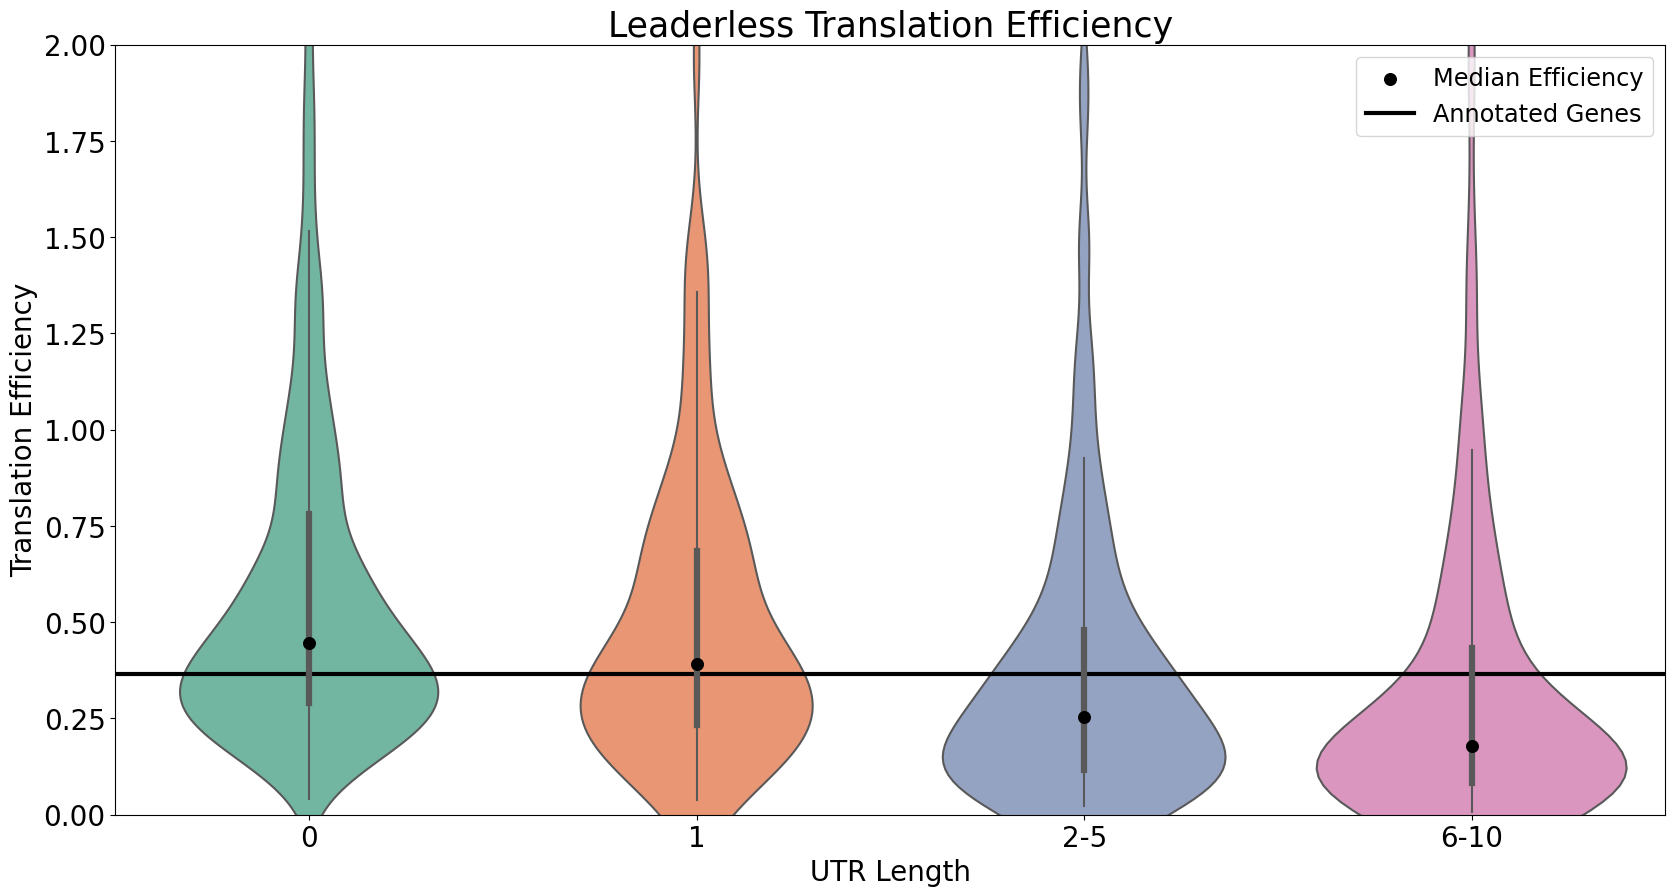

In [27]:
if (error_count==0):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.scatter(list(categories)[1:], efficiency_list[1:], color="black", s=70, zorder=4, label="Median Efficiency")
    ax.axhline(median_annotated_efficiency, color="black", label="Annotated Genes", lw=3)
    ax = sns.violinplot(data=no_annotated, x="UTR Length", y="Translation Efficiency", bw=0.15, scale="area", palette="Set2", gridsize=500)
    ax.set_ylim(0, 2)
    ax.xaxis.label.set_fontsize(20)
    ax.yaxis.label.set_fontsize(20)

    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

    plt.title("Leaderless Translation Efficiency", fontsize=25)
    plt.legend(fontsize='xx-large')
    plt.savefig("plots/" + "efficiency_violinplot" + ".png", format="png", dpi=1200)

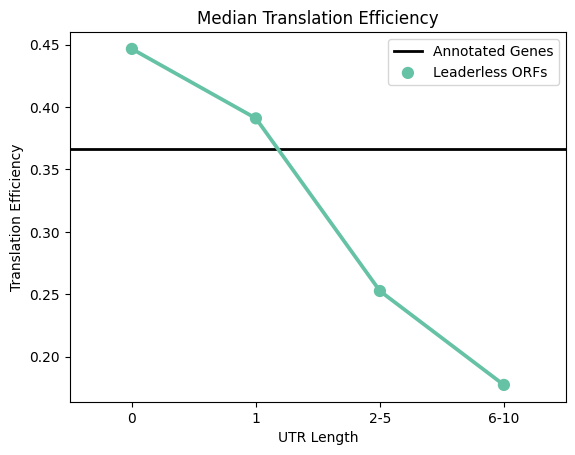

In [28]:
fig, ax = plt.subplots()
ax.axhline(median_annotated_efficiency, color="black", label="Annotated Genes", lw=2)
ax = sns.pointplot(x=list(categories)[1:], y=efficiency_list[1:], label = "Leaderless ORFs")

ax.set_xlabel("UTR Length")
ax.set_ylabel("Translation Efficiency")

plt.title("Median Translation Efficiency")
plt.legend()

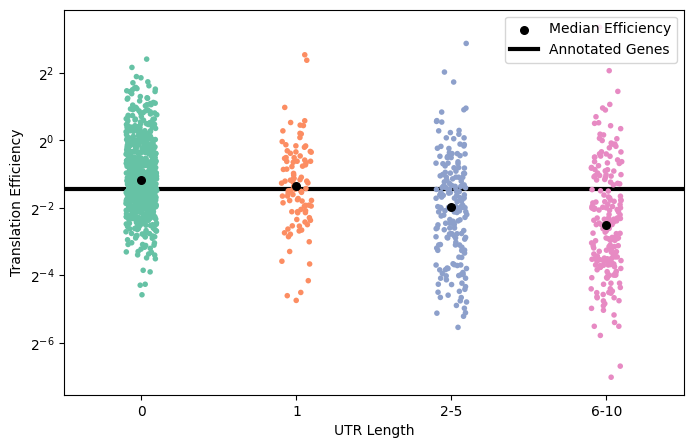

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(list(categories)[1:], efficiency_list[1:], color="black", s=30, zorder=5, label="Median Efficiency")
ax.axhline(median_annotated_efficiency, color="black", label="Annotated Genes", lw=3)
sns.stripplot(data=no_annotated, x="UTR Length", y="Translation Efficiency", hue="UTR Length", ax=ax, size=4)
ax.set_yscale('log', base=2)

#ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
ax.legend(handles=h[0:2], loc='upper right')

## Export Data

### ORF/Intensity Dataframes

In [30]:
for i in range(6):
    utr_length = i
    intensity_df_pos, intensity_df_neg = quick_df(utr_length, include_flags=True)
    pos_name = ("utr_pos_" + str(utr_length))
    neg_name = ("utr_neg_" + str(utr_length))
    intensity_df_pos.to_csv("data/" + pos_name + ".txt", sep = "\t", header=True)
    intensity_df_neg.to_csv("data/" + neg_name + ".txt", sep = "\t", header=True)

### FASTA Protein Sequences

In [31]:
def translate_dna(base_dict_pos, base_dict_neg, utr_length):
    translated_list_pos = []
    title_list_pos = []
    for key in base_dict_pos:
        left = int(key)-1
        right = int(base_dict_pos[key])
        orf = reference_seq[left:right]
        protein = Seq(orf).translate() # predict amino acid sequences from orf nucleotide pattern
        seq_title = str(left+1) + "-" + str(right) + "+ " + str(utr_length) + " base UTR" # create custom names according to base locations & strand
        title_list_pos.append(seq_title)
        translated_list_pos.append(protein)

    translated_list_neg = []
    title_list_neg = []
    for key in base_dict_neg:
        left = int(key)-1
        right = int(base_dict_neg[key])
        orf = complement_seq[left:right]
        fliporf = orf[::-1]
        protein = Seq(fliporf).translate() # predict amino acid sequences from orf nucleotide pattern
        seq_title = str(left+1) + "-" + str(right) + "- " + str(utr_length) + " base UTR" # create custom names according to base locations & strand
        title_list_neg.append(seq_title)
        translated_list_neg.append(protein)
        
    return translated_list_pos, title_list_pos, translated_list_neg, title_list_neg

In [32]:
def write_fasta(pos_list, pos_titles, neg_list, neg_titles, drop_matches):   
    fasta = ""
    for i in range(len(pos_list)):
        prot = str(pos_list[i][:-1])
        if (prot in fasta_seqs):
            if (drop_matches == False):
                match_loc = fasta_seqs.index(prot)
                title = ">" + pos_titles[i] + " " + fasta_seqs[match_loc-1] + "\n"
                sequence = str(pos_list[i]) + "\n"
            else:
                title = ""
                sequence = ""
        else:
            title = ">" + pos_titles[i] + " " + "\n"
            sequence = str(pos_list[i]) + "\n"
        fasta = fasta + title + sequence

    for i in range(len(neg_list)):
        prot = str(neg_list[i][:-1])
        if (prot in fasta_seqs):
            if (drop_matches == False):
                match_loc = fasta_seqs.index(prot)
                title = ">" + neg_titles[i] + " " + fasta_seqs[match_loc-1] + "\n"
                sequence = str(neg_list[i]) + "\n"
            else:
                title = ""
                sequence = ""
        else:
            title = ">" + neg_titles[i] + "\n"
            sequence = str(neg_list[i]) + "\n"
        fasta = fasta + title + sequence

    return fasta

In [33]:
def export_fasta(fasta, file_path):
    with open(file_path + ".fasta", "w") as f:
        f.write(fasta)

In [34]:
%cd 'Mtb_inputs'
fasta_seqs = []
for seq_record in SeqIO.parse(open("protein_FASTA.fasta", mode="r"), "fasta"):
    fasta_seqs.append(seq_record.description)
    fasta_seqs.append(seq_record.seq)

/Users/annamccartan/Downloads/Leaderless-Efficiency/Mtb_inputs


In [35]:
%cd '..'
master_fasta = ""
file_path = "fastas/"
for i in range(6):
    # create dataframes of unflagged orfs on both strands
    utr_length = i
    intensity_df_pos_noflags, intensity_df_neg_noflags = quick_df(utr_length, include_flags=False)
    
    # record/store original endpoints of each orf
    orf_dict_pos_noflags = dict(zip(intensity_df_pos_noflags["Initial Left"], intensity_df_pos_noflags["Initial Right"]))
    orf_dict_neg_noflags = dict(zip(intensity_df_neg_noflags["Initial Left"], intensity_df_neg_noflags["Initial Right"]))

    # translate & name orfs
    pos_protein_list, pos_title_list, neg_protein_list, neg_title_list = translate_dna(orf_dict_pos_noflags, orf_dict_neg_noflags, utr_length)
    
    # write & export fasta sequence
    fasta = write_fasta(pos_protein_list, pos_title_list, neg_protein_list, neg_title_list, drop_matches=False)
    master_fasta = master_fasta + fasta
    export_fasta(fasta, file_path + str(utr_length))

export_fasta(master_fasta, file_path + "all")

/Users/annamccartan/Downloads/Leaderless-Efficiency


### RiboRET Visualization
#### Import ribo-ret data: base values and corresponding ribosomal intensity (.txt files)

In [36]:
%cd 'Mtb_inputs'
# import RiboRET data
riboret_aplus = pd.read_csv("Ribo-RET footprint 3- ends a plus.bedgraph", sep = "\t", skiprows=1, header=None)
riboret_aminus = pd.read_csv("Ribo-RET footprint 3- ends a minus.bedgraph", sep = "\t", skiprows=1, header=None)
riboret_bplus = pd.read_csv("Ribo-RET footprint 3- ends b plus.bedgraph", sep = "\t", skiprows=1, header=None)
riboret_bminus = pd.read_csv("Ribo-RET footprint 3- ends b minus.bedgraph", sep = "\t", skiprows=1, header=None)

# from RiboRET data, create dictionary relating base to intensity
ribo_ret_dict_aplus = dict (zip(riboret_aplus[2], riboret_aplus[3]))
ribo_ret_dict_aminus = dict (zip(riboret_aminus[2], riboret_aminus[3]))
ribo_ret_dict_bpos = dict (zip(riboret_bplus[2], riboret_bplus[3]))
ribo_ret_dict_bminus = dict (zip(riboret_bminus[2], riboret_bminus[3]))

/Users/annamccartan/Downloads/Leaderless-Efficiency/Mtb_inputs


In [37]:
# given a dictionary and base value, returns corresponding intensity
def base_to_intensity(base_val, reference_dict):
    intensity = reference_dict.get(base_val)
    return intensity

In [38]:
# calculates mean, normalized Ribo-RET values 50 bases downstream from TSS & displays in dataframe
# varying utr_length value affects length of 5" UTR (number of bases b/w TSS & start codon)
def create_scaled_df(utr_length):
    
    tss_match_list_pos, tss_match_list_neg = find_tss_matches(utr_length) 
    
    # merge RiboRET dictionary and TSS list to create dataframe    
    riboret_aplus_df = pd.DataFrame(tss_match_list_pos) # rows are aligned TSS
    for i in range(1,51): # columns are 50 bases downstream from TSS
        riboret_aplus_df[i]=riboret_aplus_df[0]+i

    riboret_aplus_df = riboret_aplus_df.applymap(lambda x: base_to_intensity(x, ribo_ret_dict_aplus)) # cells show related intensity
    riboret_aplus_df[0] = tss_match_list_pos
    riboret_aplus_df = riboret_aplus_df.fillna(0) # replace NaN values with zero
    
    ribo_ret_bplus_df = pd.DataFrame(tss_match_list_pos)
    for i in range(1,51):
        ribo_ret_bplus_df[i]=ribo_ret_bplus_df[0]+i

    ribo_ret_bplus_df = ribo_ret_bplus_df.applymap(lambda x: base_to_intensity(x, ribo_ret_dict_bpos))
    ribo_ret_bplus_df[0] = tss_match_list_pos
    ribo_ret_bplus_df = ribo_ret_bplus_df.fillna(0)
    
    ribo_ret_aminus_df = pd.DataFrame(tss_match_list_neg)
    for i in range(1,51):
        ribo_ret_aminus_df[i]=ribo_ret_aminus_df[0]-i

    ribo_ret_aminus_df = ribo_ret_aminus_df.applymap(lambda x: base_to_intensity(x, ribo_ret_dict_aminus))
    ribo_ret_aminus_df[0] = tss_match_list_neg
    ribo_ret_aminus_df = ribo_ret_aminus_df.fillna(0)
    
    ribo_ret_bminus_df = pd.DataFrame(tss_match_list_neg)
    for i in range(1,51):
        ribo_ret_bminus_df[i]=ribo_ret_bminus_df[0]-i

    ribo_ret_bminus_df = ribo_ret_bminus_df.applymap(lambda x: base_to_intensity(x, ribo_ret_dict_bminus))
    ribo_ret_bminus_df[0] = tss_match_list_neg
    ribo_ret_bminus_df = ribo_ret_bminus_df.fillna(0)
    
    frames = [riboret_aplus_df, ribo_ret_bplus_df, ribo_ret_aminus_df, ribo_ret_bminus_df]
    df = pd.concat(frames) # combine replicates & positive/negative strand into one dataframe
     
    scaled_df = df.copy()
    scaled_df[0] = math.nan
    scaled_df = scaled_df.T # transpose data

    # normalize each value relative to column range
    for column in scaled_df.columns:
        scaled_df[column] = (scaled_df[column] - scaled_df[column].min()) / (scaled_df[column].max() - scaled_df[column].min())

    scaled_df = scaled_df.T # transpose data back
    scaled_df.loc["mean_value"] = scaled_df.mean() # add row of column averages

    return scaled_df

#### Plot ribo-ret intensity for 50 bases downstream from start sites, where start sites are identified for varying UTR lengths

In [39]:
# plots dataframe as layered line graph
def plot_line_graph(scaled_df, utr_length):
    x_axis = list(range(1,51)) # store x axis values as list: bases 1-50
    y_vals = scaled_df.values.tolist() # store y axis values: mean values for each upstream base
    last_row = len(scaled_df)-1
    y_axis = y_vals[last_row]
    del y_axis[0]
    if (utr_length == 1):
        ax = plt.plot(x_axis, y_axis, label = (str(utr_length) + " base"))
    else:
        ax = plt.plot(x_axis, y_axis, label = (str(utr_length) + " bases"))

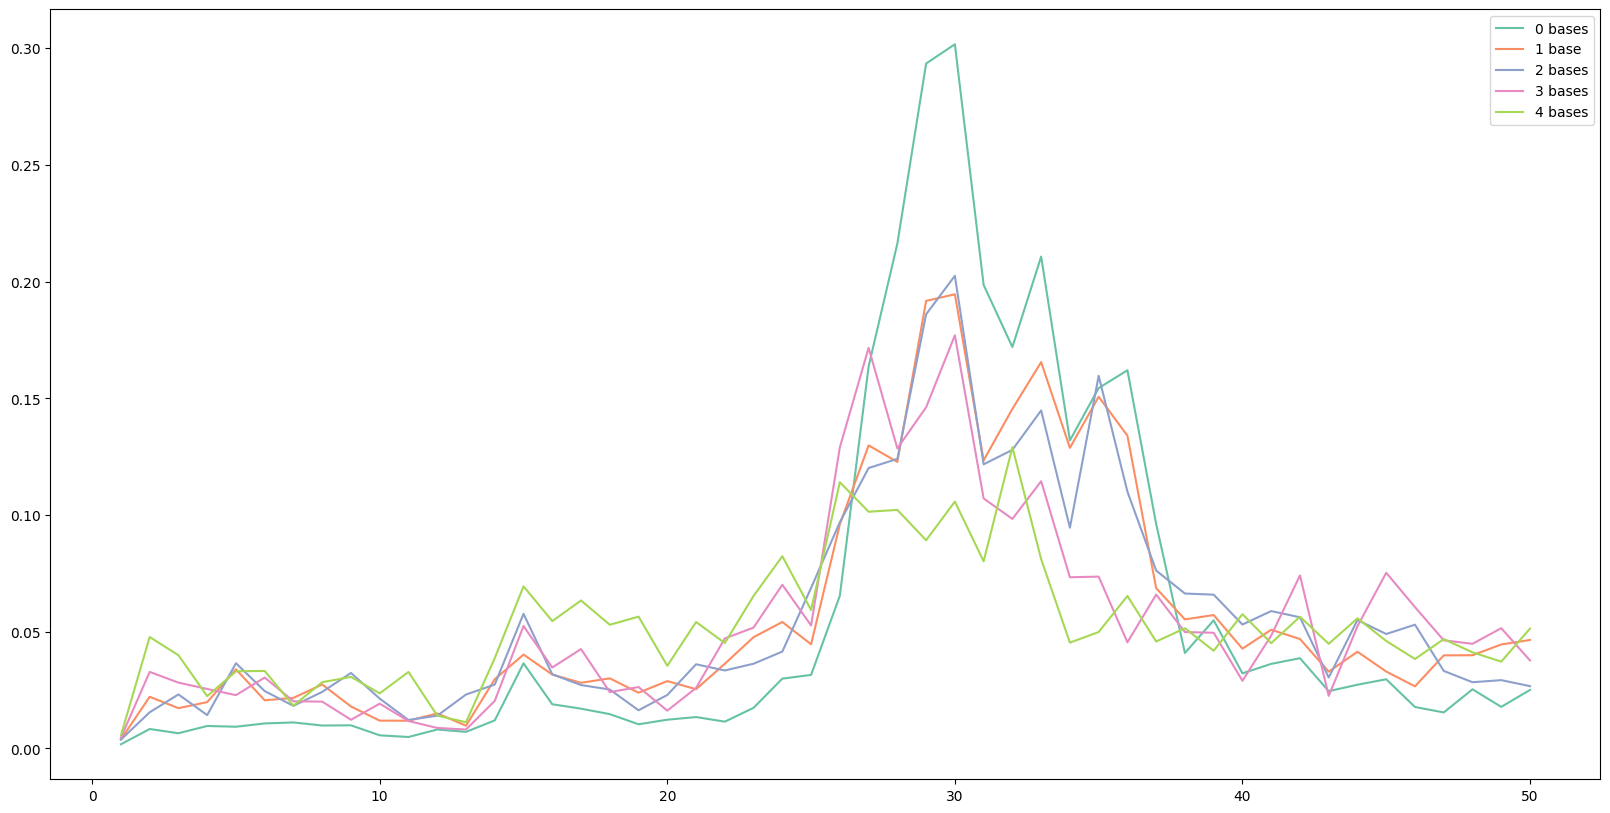

In [40]:
fig = plt.figure(figsize=(20,10)) # adjust figure dimensions
for i in range(5): # graph data according to particular range of bases
    plot_df = create_scaled_df(i)
    plot_line_graph(plot_df, i)
    plt.legend()

#### Plot heat map showing ribo-ret intensity downstream from start site: vary UTR length

In [41]:
# plots dataframe as heatmap
def plot_heatmap(utr_length):
    heatmap_df = create_scaled_df(utr_length)
    fig = plt.figure(figsize=(5, 20))
    sns.set(font_scale = 1.25)
    if (utr_length==1):
        plt.title("Heatmap: " + str(utr_length) + " base")
    else:
        plt.title("Heatmap: " + str(utr_length) + " bases")  
    ax = sns.heatmap(heatmap_df, cmap="Greens")

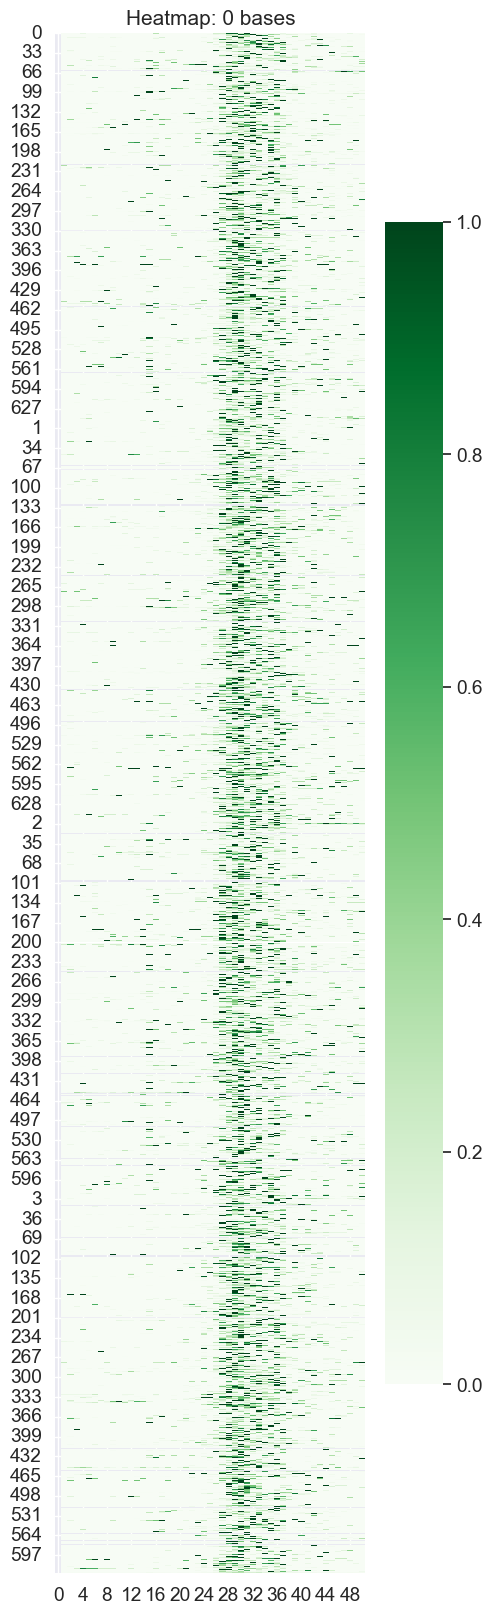

In [42]:
plot_heatmap(0)